In [139]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
import sys
from datetime import datetime
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

### Load data

In [ ]:
# Get the absolute path to the 'src' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
src_path = os.path.join(project_root, "src")

# Add 'src' to system path
if src_path not in sys.path:
    sys.path.append(src_path)

from create_Dataframe import createDataframe as create_df

merged_data_summer = create_df('summer')
merged_data_winter = create_df('winter')

c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project\src\create_Dataframe.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_summer["timestamp"] = pd.to_datetime(
c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project\src\create_Dataframe.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_winter["timestamp"] = pd.to_datetime(
c:\Users

### Dishwasher

In [ ]:
# Load data
price = merged_data_winter["Spotmarket_(EUR/kWh)"].values
inflexibles = merged_data_winter["Inflexible_Demand_(kWh)"].values

Time_interval = len(price)  # Total time interval in hours

# Dishwasher properties
duration = 3  # hours of operation
min_gap = 15  # hours between runs
power_dishwasher = 1.5  # kW during operation

# Gurobi model
model = gp.Model("automated_demand_response")

# Binary start variables: 1 if dishwasher starts at hour t
start_times = range(Time_interval - duration + 1)
dishwasher_start = model.addVars(start_times, vtype=GRB.BINARY, name="start")

# Binary on variables: 1 if dishwasher is on at hour t
binary_dishwasher = model.addVars(Time_interval, vtype=GRB.BINARY, name="on")

for t, k in itertools.product(range(len(start_times)), range(duration)):
    model.addConstr(binary_dishwasher[t + k] >= dishwasher_start[t], name=f"dishwasher_{t}_{k}")

for t in range(len(start_times)-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t + k] for k in range(duration+1)) <= 3, name=f"max_three_hours_on_{t}")


# Enforce min 1 run per day
#adds up all possible start times of the dishwasher in a single and '>= 1' day ensures that the dishwasher has to run once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(dishwasher_start[t] for t in range(d * 24, (d + 1) * 24)) == 1,
                name=f"min_one_run_per_day_dishwasher_{d}")
    
# Enforce max 1 run per day of max 3 hours
#adds up all possible start times of the dishwasher in a single and '<= 1' day ensures that the dishwasher doesn't run more than once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t] for t in range(d * 24, (d + 1) * 24)) == 3,
                name=f"max_one_run_per_day_dishwasher_{d}")

# Enforce minimum gap (15 hours) between two starts
#multiplying with min_gap so we don't constrain the dishwasher to start at the same time every day
#this enures that the optimizer can iterate through without being constrained to a single time
for t in range(len(start_times)-min_gap):
    model.addConstr(gp.quicksum(dishwasher_start[t + offset] for offset in range(1, min_gap + 1)) <= (1 - dishwasher_start[t]) * min_gap,
                name=f"min_gap_after_{t}")

model.update()

### Washing Machine

In [ ]:
### including the washing machine
# washing_machine properties
duration_wm = 2  # hours of operation
min_gap_wm = 1  # hours between runs
power_wm = 3  # kW during operation -> should be double checked
wm_runs_per_week = 4

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# Binary start variables: 1 if washing machine starts at hour t

start_times_wm = range(Time_interval - duration_wm + 1)
wm_start = model.addVars(start_times_wm, vtype=GRB.BINARY, name="start_wm")

# Binary on variables: 1 if washing machine is on at hour t

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# When washing machine is on, it must be running -> wm_start is 1 -> binary_wm at the same time + duration_wm is 1 

for t, k in itertools.product(range(len(start_times_wm)), range(duration_wm)):
    model.addConstr(binary_wm[t + k] >= wm_start[t], name=f"wm_{t}_{k}")

for t in range(len(start_times_wm)-duration_wm):
    model.addConstr(gp.quicksum(binary_wm[t + k] for k in range(duration_wm+1)) <= duration_wm, name=f"wm_max_two_hours_on_{t}")


# Enforce min 4 runs per week -> if negative prices, can run more than 4 times, for now: exactly 4 times
#adds up all possible start times of the washing machine in a single week and '>= 1' day ensures that the washing machine has to run 4 times per week

hours_per_week = 24*7
weeks = Time_interval // hours_per_week
for week in range(weeks):
    model.addConstr(gp.quicksum(wm_start[t] for t in range(week * 24 * 7, (week + 1) * 24 * 7 -1)) == wm_runs_per_week,
                name=f"wm_four_runs_per_week_{week}")


# Enforce minimum gap (1 hour) between two starts

for t in range(len(start_times_wm)-min_gap_wm):
    model.addConstr(gp.quicksum(wm_start[t + offset] for offset in range(1, min_gap_wm + 1)) <= (1 - wm_start[t]) * min_gap_wm,
                name=f"min_gap_after_washing_wm_{t}")
    
#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
merged_data_summer['Allowed_WM_summer'] = 0  # Initialize with 0
merged_data_winter['Allowed_WM_winter'] = 0  # Initialize with 0

# Define the conditions for weekdays and weekends -> for summer and winter
for index, row in merged_data_summer.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 20) or (day_of_week >= 5 and 8 <= hour < 20):
        merged_data_summer.loc[index, 'Allowed_WM_summer'] = 1
    else: 
        merged_data_summer.loc[index, 'Allowed_WM_summer'] = 0


for index, row in merged_data_winter.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 20) or (day_of_week >= 5 and 8 <= hour < 20):
        merged_data_winter.loc[index, 'Allowed_WM_winter'] = 1
    else: 
        merged_data_winter.loc[index, 'Allowed_WM_winter'] = 0
        
#model.addConstrs((binary_wm[t] <= merged_data_summer['Allowed_WM_summer'][t] for t in range(len(binary_wm))), name="allowed_wm_summer")
model.addConstrs((binary_wm[t] <= merged_data_winter['Allowed_WM_winter'][t] for t in range(len(binary_wm))), name="allowed_wm_winter") #implement later

model.update()

### Dryer 

In [ ]:
### including the dryer
# dryer properties
duration_dryer = 2  # hours of operation
max_gap_wm_dryer = 2  # hours between washing machine end and dryer start
power_dryer = 3  # kW during operation -> should be double checked


binary_dryer = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_dryer")

# Binary start variables: 1 if dryer starts at hour t

start_times_dryer = range(Time_interval - duration_dryer + 1)
dryer_start = model.addVars(start_times_dryer, vtype=GRB.BINARY, name="start_dryer")

# Binary on variables: 1 if dryer is on at hour t

binary_dryer = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_dryer")

# When dryer is on, it must be running -> dryer_start is 1 -> binary_dryer at the same time + duration_dryer is 1 

for t, k in itertools.product(range(len(start_times_dryer)), range(duration_dryer)):
    model.addConstr(binary_dryer[t + k] >= dryer_start[t], name=f"dryer_{t}_{k}")

for t in range(len(start_times_dryer)-duration_dryer):
    model.addConstr(gp.quicksum(binary_dryer[t + k] for k in range(duration_dryer+1)) <= duration_dryer, name=f"dryer_max_two_hours_on_{t}")


# Enforce minimum gap of 0 hours and max gap of 2 hours between two end of washing machine and start of dryer



# Enforce that the dryer starts within max_gap_wm_dryer hours after the washing machine ends
for t in range(len(dryer_start)-max_gap_wm_dryer-duration_wm):
    model.addConstr(gp.quicksum(dryer_start[t + offset + duration_wm] for offset in range(0, max_gap_wm_dryer + 1)) >= wm_start[t],
                name=f"max_gap_after_washing_dryer_{t}")



#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
merged_data_summer['Allowed_dryer_summer'] = 0  # Initialize with 0
merged_data_winter['Allowed_dryer_winter'] = 0  # Initialize with 0

# Define the conditions for weekdays and weekends -> for summer and winter
for index, row in merged_data_summer.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 22) or (day_of_week >= 5 and 8 <= hour < 22):
        merged_data_summer.at[index, 'Allowed_dryer_summer'] = 1
    else: 
        merged_data_summer.at[index, 'Allowed_dryer_summer'] = 0


for index, row in merged_data_winter.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 22) or (day_of_week >= 5 and 8 <= hour < 22):
        merged_data_winter.at[index, 'Allowed_dryer_winter'] = 1
    else: 
        merged_data_winter.at[index, 'Allowed_dryer_winter'] = 0
        
#model.addConstrs((binary_dryer[t] <= merged_data_summer['Allowed_dryer_summer'][t] for t in range(len(binary_dryer))), name="allowed_dryer_summer")
model.addConstrs((binary_wm[t] <= merged_data_winter['Allowed_WM_winter'][t] for t in range(len(binary_wm))), name="allowed_dryer_winter") #implement later

model.update()

### Heat Pump

In [144]:
# Heat pump and storage parameters
# https://www.ochsner.com/de-ch/ochsner-produkte/air-11-c11a/
COP = 4.2  # Coefficient of Performance
max_power_hp = 8  # kW, electrical power input
storage_capacity = 200  # kWh, thermal storage capacity
storage_loss_rate = 0.01  # 1% loss per hour

#binary_hp = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_hp")
power_hp = model.addVars(Time_interval, lb=0, ub=max_power_hp, vtype=GRB.CONTINUOUS, name="power_hp")
heat_output = model.addVars(Time_interval, lb=0, ub=COP*max_power_hp, vtype=GRB.CONTINUOUS, name="heat_output")
storage_level = model.addVars(Time_interval, lb=0.2*storage_capacity, ub=storage_capacity, vtype=GRB.CONTINUOUS, name="heat_storage")

# Heat output from heat pump
for t in range(Time_interval):
    model.addConstr(heat_output[t] == COP * power_hp[t], name=f"heat_output_{t}")

# Storage level dynamics
for t in range(Time_interval):
    if t == 0:
        model.addConstr(
            storage_level[t] == 0.5 * storage_capacity, name=f"storage_balance_{t}"
        )
    else:
        model.addConstr(
            storage_level[t] == storage_level[t - 1] * (1 - storage_loss_rate) + heat_output[t] - merged_data_winter['Heating_Demand_(kWh)'][t],
            name=f"storage_balance_{t}"
        )

model.update()

### PV

In [ ]:
#for power produced with the PV system, the price is 0 
# Total power consumption including fixed and dishwasher
total_load = {
    t: merged_data_winter['Inflexible_Demand_(kWh)'][t] +
       power_dishwasher * binary_dishwasher[t] +
       power_wm * binary_wm[t] + power_dryer * binary_dryer[t] + power_hp[t]
    for t in range(Time_interval)
}
#add variable for total load minus the power produced by the PV system


#add gurobi variable that finds the min between load and pv production
# Binary on variables: 1 if dishwasher is on at hour t

pv_maxed_binary = model.addVars(Time_interval, vtype=GRB.BINARY, name="pv_maxed")  # z[t] = 1 if load >= pv
M = 10000 #1.2 * merged_data_summer['PV_energy_production_kWh'].max() # Choose M large enough to cover max difference between pv and load
unmet   = model.addVars(Time_interval, lb=0.0, name="unmet_load")
curtail = model.addVars(Time_interval, lb=0.0, name="curtail_pv")

for t in range(Time_interval):
    pv = merged_data_winter['PV_energy_production_kWh'][t]
    load = total_load[t]

    # Binary switch: if PV > load → binary = 0; else 1
    model.addConstr(pv - load + unmet[t] - curtail[t] == 0, name=f"pv_load_balance_{t}")
    model.addConstr(curtail[t] <= (1-pv_maxed_binary[t]) * M , name=f"curtail_pv_{t}_2")
    model.addConstr(unmet[t] <= pv_maxed_binary[t] * M, name=f"unmet_load_{t}_2")

model.update()

### Objective Function and Optimization

In [146]:
# Objective: minimize total electricity cost
#model.setObjective(gp.quicksum(price[t] * (total_load[t] - pv_summer['PV_energy_production_kWh'][t]) * pv_maxed_binary[t] for t in range(670)), GRB.MINIMIZE)
model.setObjective(gp.quicksum(price[t] * unmet[t] - curtail[t] * 0 for t in range(Time_interval)), GRB.MINIMIZE)
model.update()
# Optimize
model.optimize()

### careful, will have to sync the time because the last week is sometimes omitted and not necessarily a full week so maybe will have to optimize over 5 weeks instead

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 13455 rows, 9404 columns and 43952 nonzeros
Model fingerprint: 0x7126812f
Variable types: 3360 continuous, 6044 integer (6044 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [2e-04, 2e-01]
  Bounds range     [1e+00, 2e+02]
  RHS range        [5e-05, 1e+04]
Presolve removed 10922 rows and 6070 columns
Presolve time: 0.20s
Presolved: 2533 rows, 3334 columns, 16294 nonzeros
Variable types: 1467 continuous, 1867 integer (1864 binary)

Root relaxation: objective 1.767104e+02, 1638 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  176.7

### Debugging

In [51]:
#debugging washing machine
wm_starts_list = []
# Output washing machine schedule
if model.status == GRB.OPTIMAL:
    print(f"Total cost: {model.ObjVal:.2f}")
    for t in range(Time_interval-duration_wm+1):
        if wm_start[t].X > 0.5:
            print(f"Washing machine starts at: {p_summer['timestamp'][t]}")
            wm_starts_list.append(p_summer['timestamp'][t])


print("Washing machine schedule:")
print(wm_starts_list)

Total cost: 97.69
Washing machine starts at: 2023-08-05 12:00:00
Washing machine starts at: 2023-08-06 08:00:00
Washing machine starts at: 2023-08-06 11:00:00
Washing machine starts at: 2023-08-06 14:00:00
Washing machine starts at: 2023-08-12 11:00:00
Washing machine starts at: 2023-08-12 14:00:00
Washing machine starts at: 2023-08-13 10:00:00
Washing machine starts at: 2023-08-13 13:00:00
Washing machine starts at: 2023-08-19 10:00:00
Washing machine starts at: 2023-08-19 13:00:00
Washing machine starts at: 2023-08-20 10:00:00
Washing machine starts at: 2023-08-20 13:00:00
Washing machine starts at: 2023-08-26 10:00:00
Washing machine starts at: 2023-08-26 13:00:00
Washing machine starts at: 2023-08-27 10:00:00
Washing machine starts at: 2023-08-27 13:00:00
Washing machine schedule:
[Timestamp('2023-08-05 12:00:00'), Timestamp('2023-08-06 08:00:00'), Timestamp('2023-08-06 11:00:00'), Timestamp('2023-08-06 14:00:00'), Timestamp('2023-08-12 11:00:00'), Timestamp('2023-08-12 14:00:00'),

In [52]:
#print timestamp and the corresponding state of the dishwasher
if model.status == GRB.OPTIMAL:
    for t in range(Time_interval):
        if binary_wm[t].X > 0.5:
            print(f"Washing Machine is ON at: {p_summer['timestamp'][t]}")
        else:
            print(f"Washing Machine is OFF at: {p_summer['timestamp'][t]}")
else:
    print("Model has not been solved to optimality. Unable to retrieve variable values.")

Washing Machine is OFF at: 2023-08-01 00:00:00
Washing Machine is OFF at: 2023-08-01 01:00:00
Washing Machine is OFF at: 2023-08-01 02:00:00
Washing Machine is OFF at: 2023-08-01 03:00:00
Washing Machine is OFF at: 2023-08-01 04:00:00
Washing Machine is OFF at: 2023-08-01 05:00:00
Washing Machine is OFF at: 2023-08-01 06:00:00
Washing Machine is OFF at: 2023-08-01 07:00:00
Washing Machine is OFF at: 2023-08-01 08:00:00
Washing Machine is OFF at: 2023-08-01 09:00:00
Washing Machine is OFF at: 2023-08-01 10:00:00
Washing Machine is OFF at: 2023-08-01 11:00:00
Washing Machine is OFF at: 2023-08-01 12:00:00
Washing Machine is OFF at: 2023-08-01 13:00:00
Washing Machine is OFF at: 2023-08-01 14:00:00
Washing Machine is OFF at: 2023-08-01 15:00:00
Washing Machine is OFF at: 2023-08-01 16:00:00
Washing Machine is OFF at: 2023-08-01 17:00:00
Washing Machine is OFF at: 2023-08-01 18:00:00
Washing Machine is OFF at: 2023-08-01 19:00:00
Washing Machine is OFF at: 2023-08-01 20:00:00
Washing Machi

In [53]:
#debugging dishwasher

dishwasher_starts_list = []
# Output dishwasher schedule
if model.status == GRB.OPTIMAL:
    print(f"Total cost: {model.ObjVal:.2f}")
    for t in range(Time_interval):
        if dishwasher_start.get(t) and dishwasher_start[t].X > 0.5:
            print(f"Dishwasher starts at: {p_summer['timestamp'][t]}")
            dishwasher_starts_list.append(p_summer['timestamp'][t])


print("Dishwasher schedule:")
print(dishwasher_starts_list)

Total cost: 97.69
Dishwasher starts at: 2023-08-01 02:00:00
Dishwasher starts at: 2023-08-02 10:00:00
Dishwasher starts at: 2023-08-03 09:00:00
Dishwasher starts at: 2023-08-04 14:00:00
Dishwasher starts at: 2023-08-05 13:00:00
Dishwasher starts at: 2023-08-06 13:00:00
Dishwasher starts at: 2023-08-07 10:00:00
Dishwasher starts at: 2023-08-08 10:00:00
Dishwasher starts at: 2023-08-09 14:00:00
Dishwasher starts at: 2023-08-10 10:00:00
Dishwasher starts at: 2023-08-11 10:00:00
Dishwasher starts at: 2023-08-12 13:00:00
Dishwasher starts at: 2023-08-13 12:00:00
Dishwasher starts at: 2023-08-14 10:00:00
Dishwasher starts at: 2023-08-15 10:00:00
Dishwasher starts at: 2023-08-16 10:00:00
Dishwasher starts at: 2023-08-17 14:00:00
Dishwasher starts at: 2023-08-18 10:00:00
Dishwasher starts at: 2023-08-19 13:00:00
Dishwasher starts at: 2023-08-20 12:00:00
Dishwasher starts at: 2023-08-21 10:00:00
Dishwasher starts at: 2023-08-22 10:00:00
Dishwasher starts at: 2023-08-23 09:00:00
Dishwasher start

In [54]:
#print timestamp and the corresponding state of the dishwasher
if model.status == GRB.OPTIMAL:
    for t in range(Time_interval):
        if binary_dishwasher[t].X > 0.5:
            print(f"Dishwasher is ON at: {p_summer['timestamp'][t]}")
        else:
            print(f"Dishwasher is OFF at: {p_summer['timestamp'][t]}")
else:
    print("Model has not been solved to optimality. Unable to retrieve variable values.")


Dishwasher is OFF at: 2023-08-01 00:00:00
Dishwasher is OFF at: 2023-08-01 01:00:00
Dishwasher is ON at: 2023-08-01 02:00:00
Dishwasher is ON at: 2023-08-01 03:00:00
Dishwasher is ON at: 2023-08-01 04:00:00
Dishwasher is OFF at: 2023-08-01 05:00:00
Dishwasher is OFF at: 2023-08-01 06:00:00
Dishwasher is OFF at: 2023-08-01 07:00:00
Dishwasher is OFF at: 2023-08-01 08:00:00
Dishwasher is OFF at: 2023-08-01 09:00:00
Dishwasher is OFF at: 2023-08-01 10:00:00
Dishwasher is OFF at: 2023-08-01 11:00:00
Dishwasher is OFF at: 2023-08-01 12:00:00
Dishwasher is OFF at: 2023-08-01 13:00:00
Dishwasher is OFF at: 2023-08-01 14:00:00
Dishwasher is OFF at: 2023-08-01 15:00:00
Dishwasher is OFF at: 2023-08-01 16:00:00
Dishwasher is OFF at: 2023-08-01 17:00:00
Dishwasher is OFF at: 2023-08-01 18:00:00
Dishwasher is OFF at: 2023-08-01 19:00:00
Dishwasher is OFF at: 2023-08-01 20:00:00
Dishwasher is OFF at: 2023-08-01 21:00:00
Dishwasher is OFF at: 2023-08-01 22:00:00
Dishwasher is OFF at: 2023-08-01 23:0

In [55]:
#print dishwasher start times
for t in range(Time_interval-2):
    if dishwasher_start[t].X > 0.5:
        print(f"Dishwasher start time: {p_summer['timestamp'][t]}")

Dishwasher start time: 2023-08-01 02:00:00
Dishwasher start time: 2023-08-02 10:00:00
Dishwasher start time: 2023-08-03 09:00:00
Dishwasher start time: 2023-08-04 14:00:00
Dishwasher start time: 2023-08-05 13:00:00
Dishwasher start time: 2023-08-06 13:00:00
Dishwasher start time: 2023-08-07 10:00:00
Dishwasher start time: 2023-08-08 10:00:00
Dishwasher start time: 2023-08-09 14:00:00
Dishwasher start time: 2023-08-10 10:00:00
Dishwasher start time: 2023-08-11 10:00:00
Dishwasher start time: 2023-08-12 13:00:00
Dishwasher start time: 2023-08-13 12:00:00
Dishwasher start time: 2023-08-14 10:00:00
Dishwasher start time: 2023-08-15 10:00:00
Dishwasher start time: 2023-08-16 10:00:00
Dishwasher start time: 2023-08-17 14:00:00
Dishwasher start time: 2023-08-18 10:00:00
Dishwasher start time: 2023-08-19 13:00:00
Dishwasher start time: 2023-08-20 12:00:00
Dishwasher start time: 2023-08-21 10:00:00
Dishwasher start time: 2023-08-22 10:00:00
Dishwasher start time: 2023-08-23 09:00:00
Dishwasher 

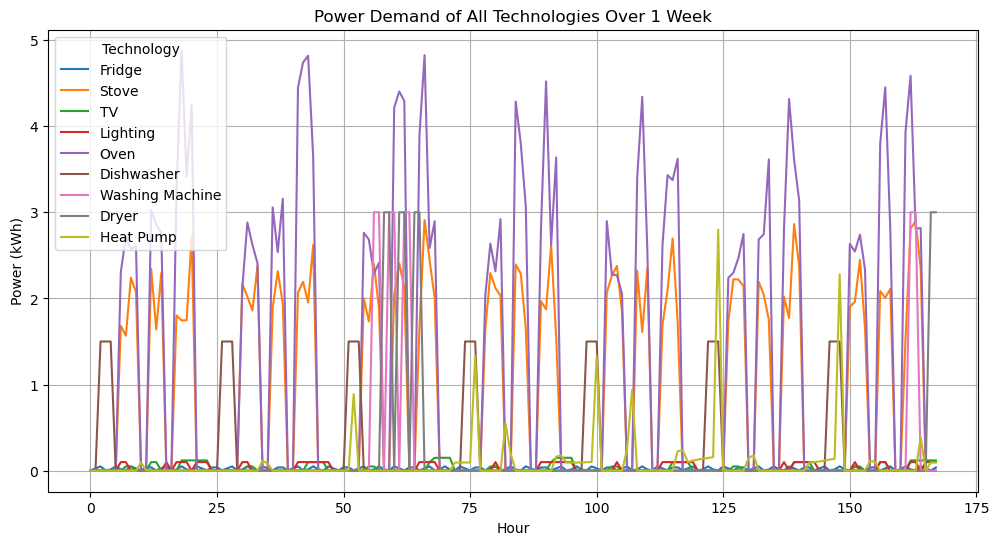

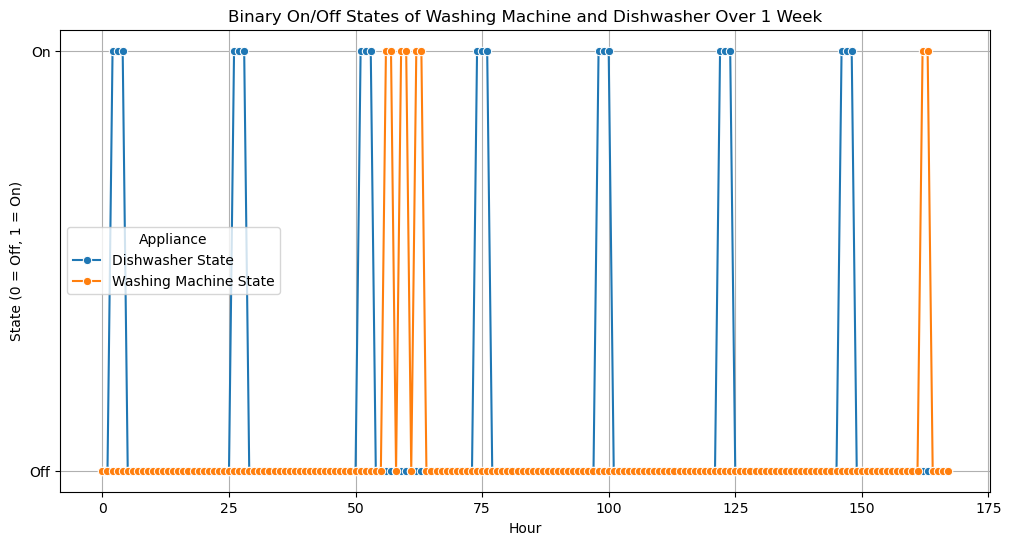

In [147]:
# Define the time range for one week
time_range = range(0, 24 * 7)  # 7 days, 24 hours each

# Create a DataFrame for the first plot
data_power = pd.DataFrame({
    'Hour': list(time_range),
    'Fridge': fridge[:len(time_range)],
    'Stove': stove[:len(time_range)],
    'TV': tv[:len(time_range)],
    'Lighting': lighting[:len(time_range)],
    'Oven': oven[:len(time_range)],
    'Dishwasher': [power_dishwasher * binary_dishwasher[t].X for t in time_range],
    'Washing Machine': [power_wm * binary_wm[t].X for t in time_range],
    'Dryer': [power_dryer * binary_dryer[t].X for t in time_range],
    'Heat Pump': [power_hp[t].X for t in time_range]
})

# Melt the data for easier plotting
data_power_melted = data_power.melt(id_vars='Hour', var_name='Technology', value_name='Power (kWh)')

# Plot 1: Power demand of all technologies
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_power_melted, x='Hour', y='Power (kWh)', hue='Technology')
plt.title('Power Demand of All Technologies Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('Power (kWh)')
plt.legend(title='Technology')
plt.grid(True)
plt.show()

# Create a DataFrame for the second plot
data_binary = pd.DataFrame({
    'Hour': list(time_range),
    'Dishwasher State': [binary_dishwasher[t].X for t in time_range],
    'Washing Machine State': [binary_wm[t].X for t in time_range]
})

# Melt the data for easier plotting
data_binary_melted = data_binary.melt(id_vars='Hour', var_name='Appliance', value_name='State')

# Plot 2: Binary on/off states of washing machine and dishwasher
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_binary_melted, x='Hour', y='State', hue='Appliance', marker='o')
plt.title('Binary On/Off States of Washing Machine and Dishwasher Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('State (0 = Off, 1 = On)')
plt.yticks([0, 1], ['Off', 'On'])
plt.legend(title='Appliance')
plt.grid(True)
plt.show()

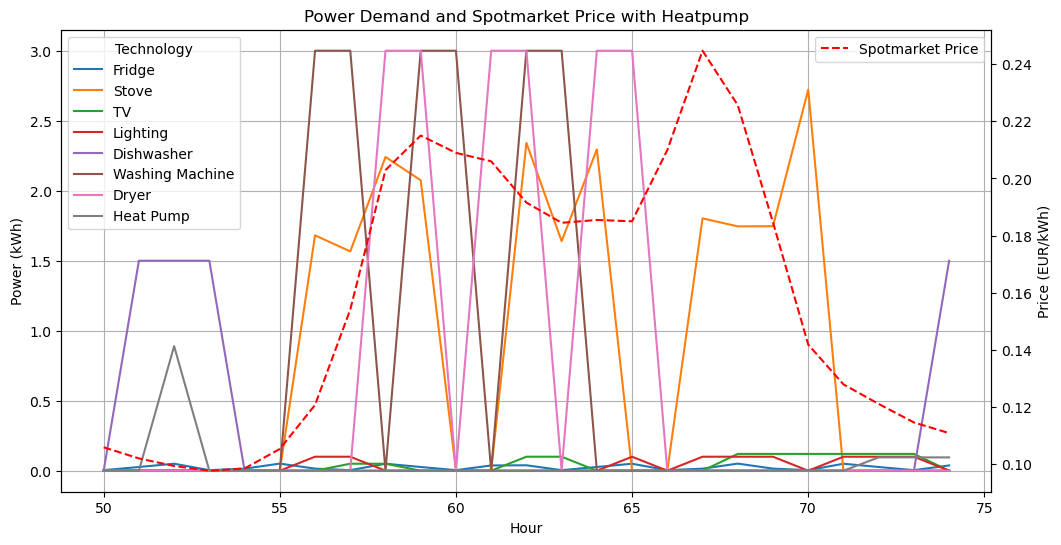

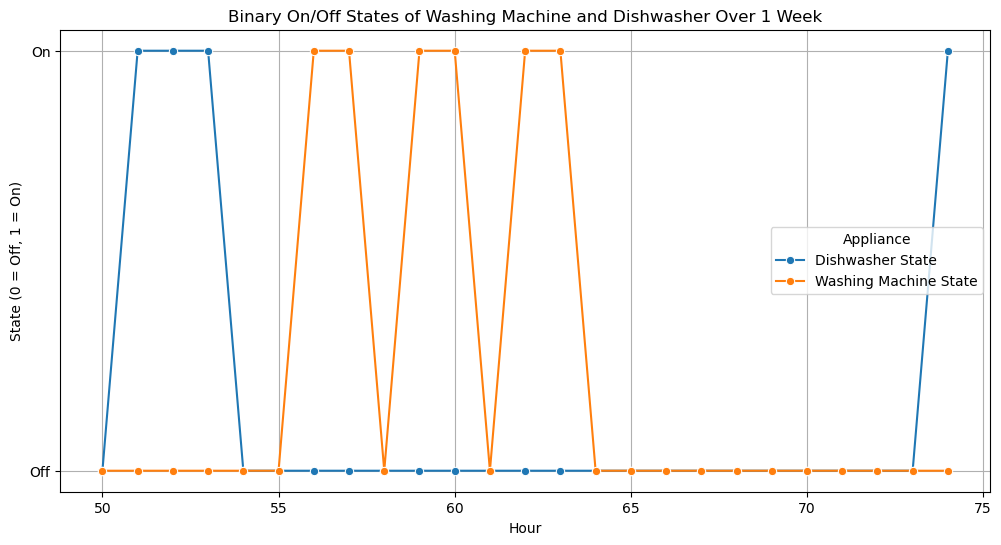

In [148]:
# Define the time range for one week
time_range = range(50,75)  # 7 days, 24 hours each

# Create a DataFrame for the first plot
data_power = pd.DataFrame({
    'Hour': list(time_range),
    'Fridge': fridge[:len(time_range)],
    'Stove': stove[:len(time_range)],
    'TV': tv[:len(time_range)],
    'Lighting': lighting[:len(time_range)],
    'Dishwasher': [power_dishwasher * binary_dishwasher[t].X for t in time_range],
    'Washing Machine': [power_wm * binary_wm[t].X for t in time_range],
    'Dryer': [power_dryer * binary_dryer[t].X for t in time_range],
    'Heat Pump': [power_hp[t].X for t in time_range],
})

# Melt the data for easier plotting
data_power_melted = data_power.melt(id_vars='Hour', var_name='Technology', value_name='Power (kWh)')
total_power = data_power_melted.groupby('Hour')['Power (kWh)'].sum().reset_index()
# Plot 1: Power demand of all technologies
plt.figure(figsize=(12, 6))
ax1 = plt.gca()

# Plot power demand (left y-axis)
sns.lineplot(data=data_power_melted, x='Hour', y='Power (kWh)', hue='Technology', ax=ax1)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Power (kWh)')
ax1.legend(title='Technology', loc='upper left')
ax1.grid(True)

# Create a second y-axis for the binary states
ax2 = ax1.twinx()
sns.lineplot(
    data=pd.DataFrame({'Hour': list(time_range), 'Price': merged_data_winter['Spotmarket_(EUR/kWh)'][:len(time_range)]}),
    x='Hour', y='Price', color='red', label='Spotmarket Price', linestyle='--', ax=ax2
)
ax2.set_ylabel('Price (EUR/kWh)')

plt.title('Power Demand and Spotmarket Price with Heatpump')
plt.show()

# Create a DataFrame for the second plot
data_binary = pd.DataFrame({
    'Hour': list(time_range),
    'Dishwasher State': [binary_dishwasher[t].X for t in time_range],
    'Washing Machine State': [binary_wm[t].X for t in time_range]
})

# Melt the data for easier plotting
data_binary_melted = data_binary.melt(id_vars='Hour', var_name='Appliance', value_name='State')

# Plot 2: Binary on/off states of washing machine and dishwasher
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_binary_melted, x='Hour', y='State', hue='Appliance', marker='o')
plt.title('Binary On/Off States of Washing Machine and Dishwasher Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('State (0 = Off, 1 = On)')
plt.yticks([0, 1], ['Off', 'On'])
plt.legend(title='Appliance')
plt.grid(True)
plt.show()

In [30]:
#lengths of the lists

print("length of pv_summer:", len(pv_summer))
print("length of merged_data_summer:", len(merged_data_summer))
print("length of merged_data_winter:", len(merged_data_winter))
print("length of p_summer:", len(p_summer))
print("length of p_winter:", len(p_winter))
print("length of fridge_summer:", len(fridge_summer))
print("length of fridge_winter:", len(fridge_winter))
print("length of oven_summer:", len(oven_summer))
print("length of oven_winter:", len(oven_winter))
print("length of induction_summer:", len(induction_summer))
print("length of induction_winter:", len(induction_winter))
print("length of tv_summer:", len(tv_summer))
print("length of tv_winter:", len(tv_winter))
print("length of lighting_summer:", len(lighting_summer))
print("length of lighting_winter:", len(lighting_winter))
print("length curtailed:", len(curtail))
print("length unmet:", len(unmet))
print("length of total_load:", len(total_load))
print("length of price:", len(price))
print("length of binary_dishwasher:", len(binary_dishwasher))




length of pv_summer: 672
length of merged_data_summer: 671
length of merged_data_winter: 671
length of p_summer: 672
length of p_winter: 672
length of fridge_summer: 672
length of fridge_winter: 672
length of oven_summer: 672
length of oven_winter: 672
length of induction_summer: 672
length of induction_winter: 672
length of tv_summer: 672
length of tv_winter: 672
length of lighting_summer: 672
length of lighting_winter: 672
length curtailed: 671
length unmet: 671
length of total_load: 671
length of price: 671
length of binary_dishwasher: 671


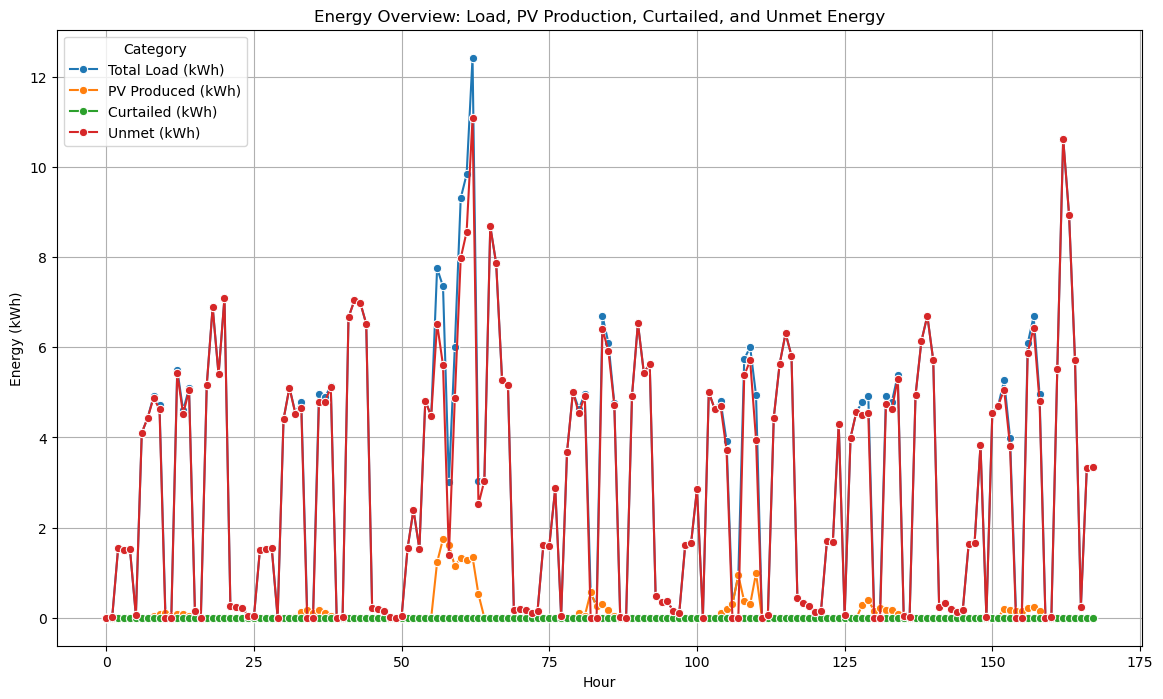

In [ ]:
# Prepare data for plotting
time_range = range(Time_interval)  # Full time range
# Limit the time range to the first two weeks (2 weeks * 7 days * 24 hours = 336 hours)
time_range = range(0, 24 * 7)

data_plot = pd.DataFrame({
    'Hour': list(time_range),
    'Total Load (kWh)': [total_load[t].getValue() for t in time_range],
    'PV Produced (kWh)': pv_winter['PV_energy_production_kWh'].iloc[:24*7].values,
    'Curtailed (kWh)': [curtail[t].X for t in time_range],
    'Unmet (kWh)': [unmet[t].X for t in time_range]
})

# Melt the data for easier plotting
data_plot_melted = data_plot.melt(id_vars='Hour', var_name='Category', value_name='Energy (kWh)')

# Plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=data_plot_melted, x='Hour', y='Energy (kWh)', hue='Category', marker='o')
plt.title('Energy Overview: Load, PV Production, Curtailed, and Unmet Energy')
plt.xlabel('Hour')
plt.ylabel('Energy (kWh)')
plt.legend(title='Category')
plt.grid(True)
plt.show()

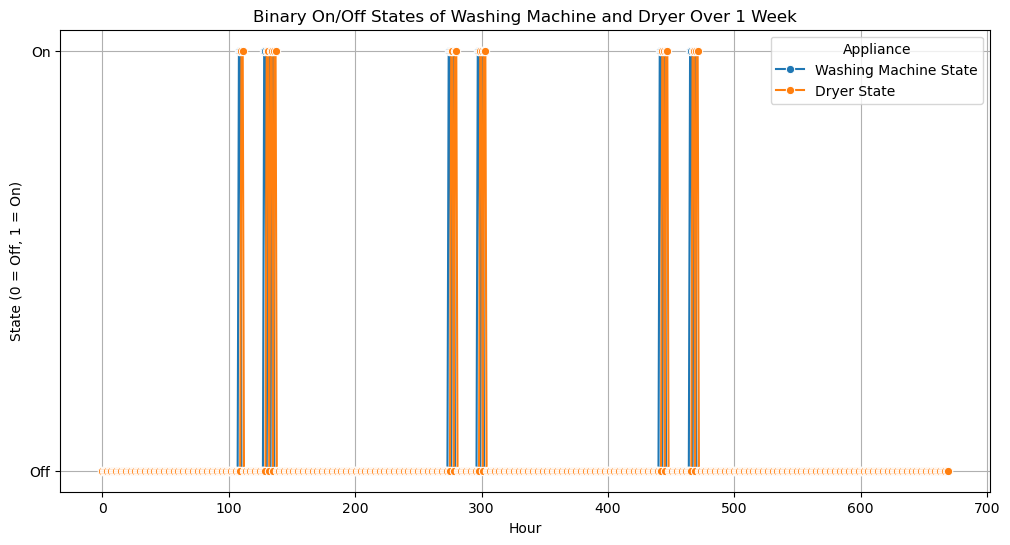

In [80]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# Define the time range for one week (or adjust as needed)
time_range = range(0,670)  # 7 days, 24 hours each

# Prepare DataFrame for binary on/off states
data_binary = pd.DataFrame({
    'Hour': list(time_range),
    'Washing Machine State': [binary_wm[t].X for t in time_range],
    'Dryer State': [binary_dryer[t].X for t in time_range]
})

# Melt for plotting
data_binary_melted = data_binary.melt(id_vars='Hour', var_name='Appliance', value_name='State')

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_binary_melted, x='Hour', y='State', hue='Appliance', marker='o')
plt.title('Binary On/Off States of Washing Machine and Dryer Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('State (0 = Off, 1 = On)')
plt.yticks([0, 1], ['Off', 'On'])
plt.legend(title='Appliance')
plt.grid(True)
plt.show()